In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
tf.version.VERSION

'2.8.0'

In [3]:
tf.config.list_physical_devices("GPU")

[]

In [4]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from pathlib import Path

data_dir = Path("/content/drive/MyDrive/ML/CanDrink/data/train")

In [6]:
[f for f in data_dir.iterdir()]

[PosixPath('/content/drive/MyDrive/ML/CanDrink/data/train/pepsi'),
 PosixPath('/content/drive/MyDrive/ML/CanDrink/data/train/sprite'),
 PosixPath('/content/drive/MyDrive/ML/CanDrink/data/train/coca-cola')]

In [7]:
list(map(lambda d: len(list(d.iterdir())), data_dir.iterdir()))

[299, 295, 199]

## Training

### Parameter

In [8]:
batch_size = 32
image_height = 224
image_width = 224
seed = 31337
epochs = 15

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(image_height, image_width),
    batch_size=batch_size,
)

Found 793 files belonging to 3 classes.
Using 635 files for training.


In [10]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(image_height, image_width),
    batch_size=batch_size,
)

Found 793 files belonging to 3 classes.
Using 158 files for validation.


In [11]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['coca-cola', 'pepsi', 'sprite']

In [12]:
checkpoint_path = "/tmp/checkpoint"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
)

### Preprocessing

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1.0 / 255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9784343


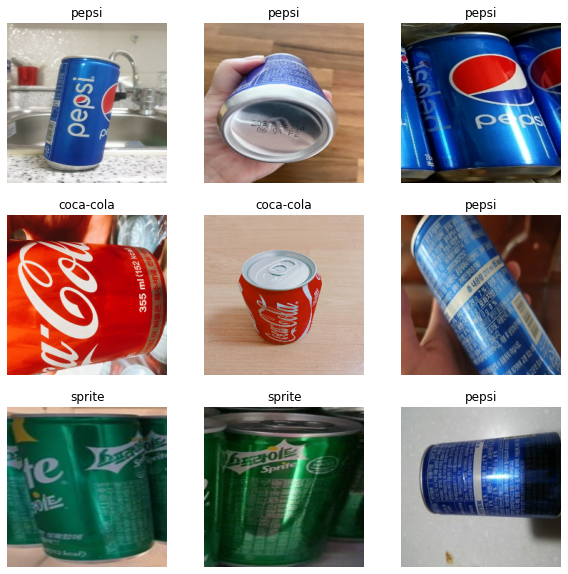

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [17]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(image_height, image_width, 3)
        ),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

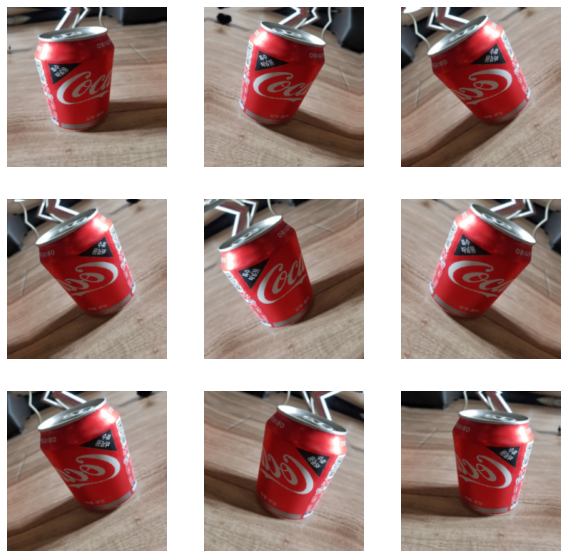

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Model

In [19]:
model = models.Sequential(
    [
        data_augmentation,
        layers.experimental.preprocessing.Rescaling(1.0 / 255),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPool2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPool2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPool2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes),
    ]
)

In [20]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [22]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpoint, early_stopping],
)

Epoch 1/15
20/20 [==============================] - 39s 2s/step - loss: 1.1640 - accuracy: 0.5890 - val_loss: 0.3665 - val_accuracy: 0.9367
Epoch 2/15
20/20 [==============================] - 35s 2s/step - loss: 0.2381 - accuracy: 0.9228 - val_loss: 0.0703 - val_accuracy: 0.9873
Epoch 3/15
20/20 [==============================] - 36s 2s/step - loss: 0.0640 - accuracy: 0.9874 - val_loss: 0.0301 - val_accuracy: 0.9937
Epoch 4/15
20/20 [==============================] - 35s 2s/step - loss: 0.0574 - accuracy: 0.9827 - val_loss: 0.0444 - val_accuracy: 0.9810
Epoch 5/15
20/20 [==============================] - 35s 2s/step - loss: 0.0428 - accuracy: 0.9843 - val_loss: 0.0292 - val_accuracy: 0.9873
Epoch 6/15
20/20 [==============================] - 39s 2s/step - loss: 0.0323 - accuracy: 0.9937 - val_loss: 0.0345 - val_accuracy: 0.9873
Epoch 7/15
20/20 [==============================] - 35s 2s/step - loss: 0.0223 - accuracy: 0.9921 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 8/15
20/20 [==

In [23]:
model.load_weights(checkpoint_path)

In [24]:
from datetime import datetime

model.save(f"/content/drive/MyDrive/ML/CanDrink/model/can-drink_{datetime.now().isoformat(timespec='seconds')}.h5")

### Visualization

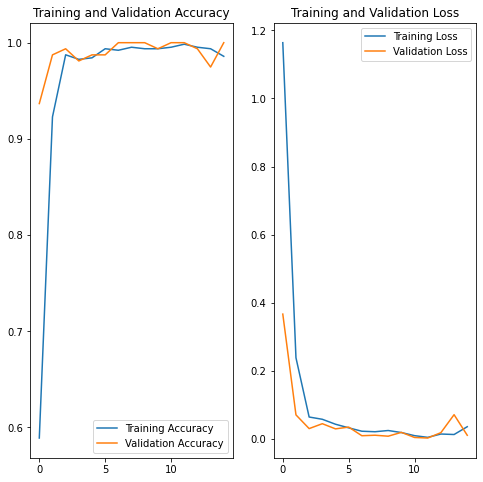

In [25]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## Prediction

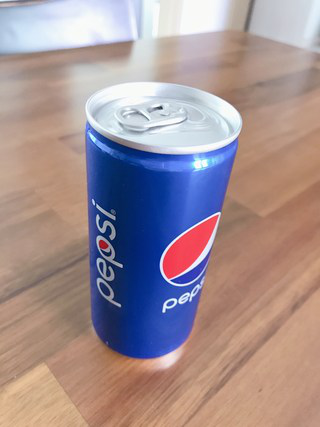

In [51]:
image = Image.open(str(list(data_dir.glob("pepsi/*"))[0]))
image

In [52]:
image = np.array(image).astype("float32") / 255
image = tf.image.resize(image, (image_height, image_width))
image = np.expand_dims(image, axis=0)

In [53]:
def predict(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path)

    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.array([image])  # Convert single image to a batch.
    image = tf.image.resize(image, (image_height, image_width))

    prediction = model.predict(image)
    return class_names[np.argmax(prediction)]

In [54]:
predict(str(list(data_dir.glob("pepsi/*"))[52]))

'pepsi'

In [55]:
predict(str(list(data_dir.glob("coca-cola/*"))[123]))

'coca-cola'

In [56]:
predict(str(list(data_dir.glob("sprite/*"))[83]))

'sprite'